# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Data

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Helper functions

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ["Age_categories", "Fare_categories", 
                "Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, col)
        
    return df

# Process data

In [5]:
train = pre_process(train)
holdout = pre_process(holdout)

# Data exploration

## SibSp and Parch
**SibSp** –
The number of siblings or spouses the passenger had aboard the Titanic

**Parch** –
The number of parents or children the passenger had aboard the Titanic

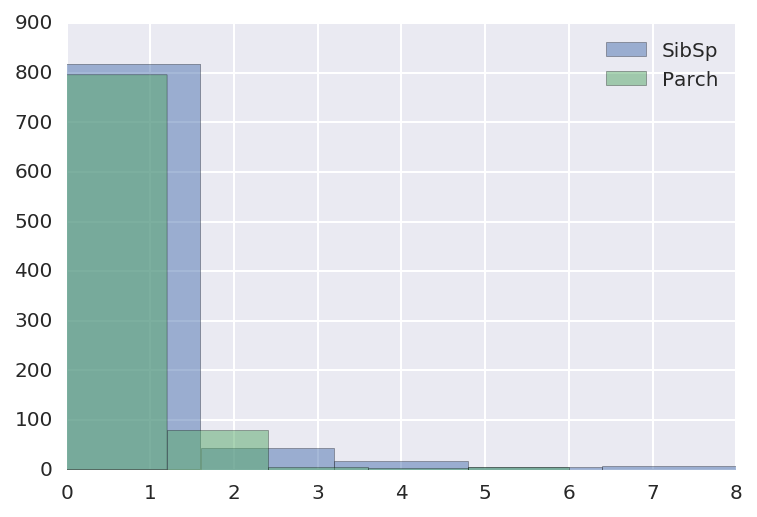

In [6]:
train['SibSp'].hist(alpha=0.5, bins=5)
train['Parch'].hist(alpha=0.5, bins=5)
plt.legend(['SibSp', 'Parch']);

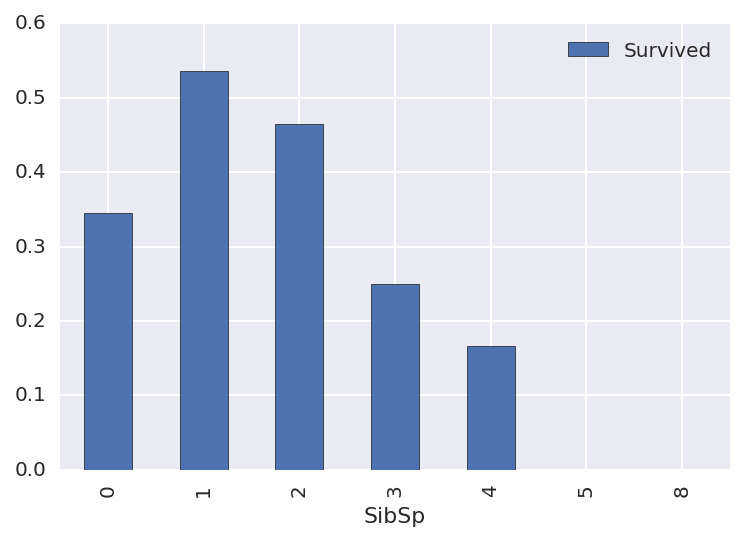

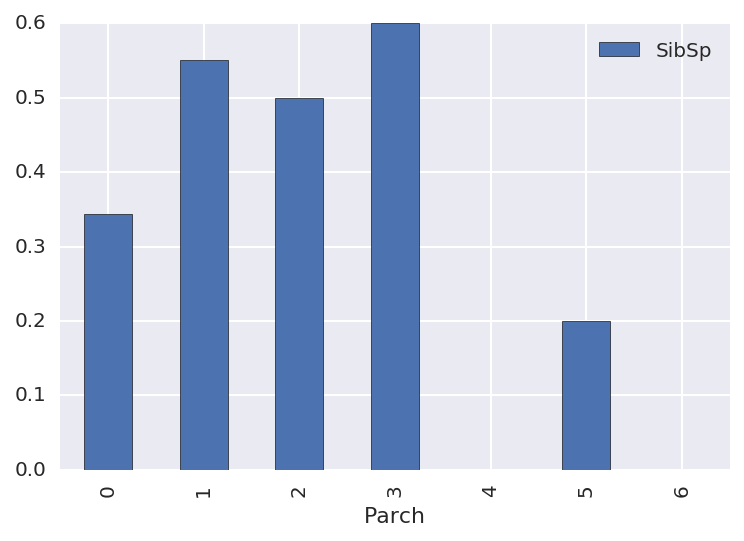

In [7]:
train.pivot_table(index='SibSp', values='Survived').plot.bar()
train.pivot_table(index='Parch', values='Survived').plot.bar()
plt.legend(['SibSp', 'Parch']);

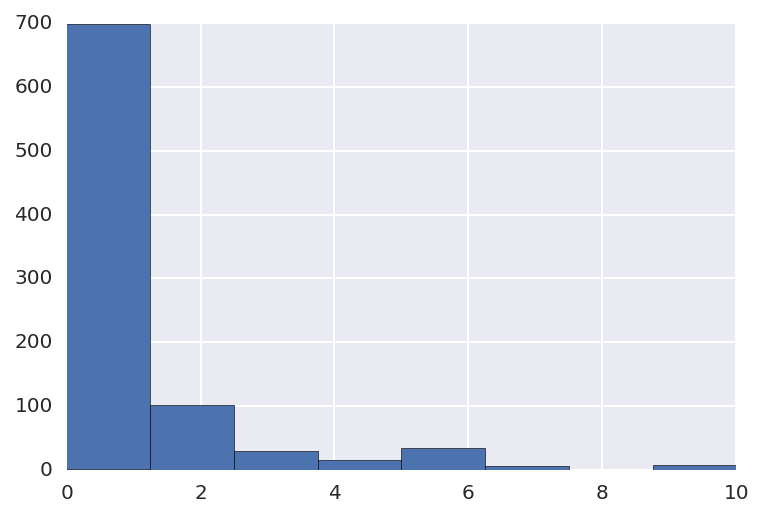

In [8]:
train['family_size'] = train['SibSp'] + train['Parch']
train['family_size'].hist(bins=8);

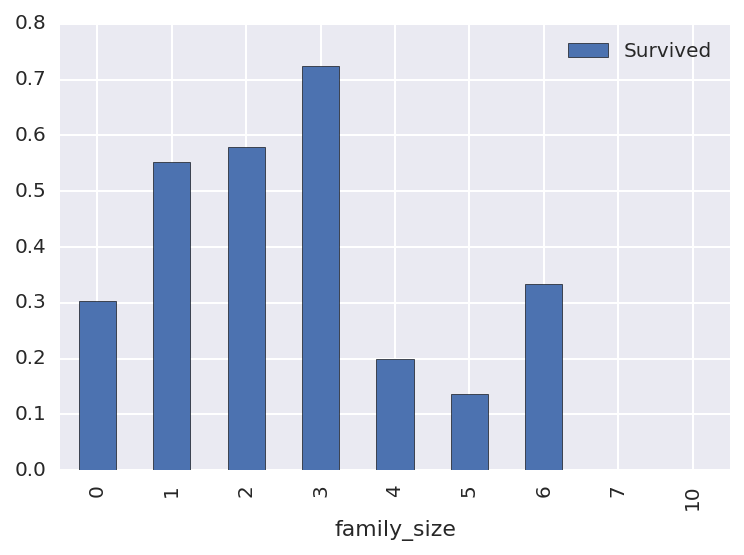

In [9]:
train.pivot_table(index='family_size', values='Survived').plot.bar();

# New features

Is passenger alone?

In [10]:
def isalone(passenger):
    if passenger['family_size'] == 0:
        return 1
    return 0

In [11]:
holdout['family_size'] = holdout['SibSp'] + holdout['Parch']
train['is alone'] = train.apply(isalone, axis=1)
holdout['is alone'] = holdout.apply(isalone, axis=1)

# Feature selection

In [12]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(columns=['Survived', 'PassengerId'])
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = all_X.columns[selector.support_].tolist()
    print("-"*12+"\n{}\n".format(best_columns))
    return best_columns

In [13]:
columns = select_features(train)

------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size', 'is alone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


# Model selection

In [18]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    
    for model in models:
        print(model['name'])
        grid = GridSearchCV(model['estimator'],
                           param_grid=model['hyperparameters'], cv =10)
        grid.fit(all_X, all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best score: ", model['best_score'])
        print("Best params: ", model['best_params'])
        
        print("—"*20, "\n")
        
    return models


result = select_model(train, columns)

LogisticRegression
Best score:  0.819304152637486
Best params:  {'solver': 'lbfgs'}
———————————————————— 

KNeighborsClassifier
Best score:  0.7800224466891134
Best params:  {'algorithm': 'kd_tree', 'weights': 'uniform', 'n_neighbors': 3, 'p': 1}
———————————————————— 

RandomForestClassifier
Best score:  0.8406285072951739
Best params:  {'min_samples_split': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 9, 'criterion': 'entropy', 'max_depth': 10}
———————————————————— 



# Submit

In [19]:
def save_submission_file(model, cols, filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    submission = pd.DataFrame({
        "PassengerId": holdout["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [20]:
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, columns)